#Libraries

---




In [1]:
import os
import math
import pandas as pd
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
import argparse
import logging
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from torch import Tensor
import torchvision.datasets as datasets
import torchvision.transforms as transforms

!pip install git+https://github.com/rtqichen/torchdiffeq

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
sns.color_palette("bright")
import matplotlib.cm as cm

use_cuda = torch.cuda.is_available()

  Cloning https://github.com/rtqichen/torchdiffeq to /tmp/pip-req-build-ros8wdx0
  Running command git clone -q https://github.com/rtqichen/torchdiffeq /tmp/pip-req-build-ros8wdx0
  Created wheel for torchdiffeq: filename=torchdiffeq-0.2.2-py3-none-any.whl size=31199 sha256=bf37164ae4c2e2cec2e5c406b873729596f1d66834953fe18803033591d6388a
  Stored in directory: /tmp/pip-ephem-wheel-cache-444p4aj7/wheels/42/b5/d4/aeb3622995bff5e90fcc0c0ef799a6951e48daaf17e293281e
Successfully built torchdiffeq


#Neural ODE implementation

Implement any ordinary differential equation initial value solver. For the sake of simplicity it'll be Euler's ODE initial value solver, however any explicit or implicit method will do.

In [ ]:
def ode_solve(z0, t0, t1, f):
    """
    Simplest Euler ODE initial value solver
    """
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z

We also implement a superclass of parameterized dynamics function in the form of neural network with a couple useful methods.

First, one needs to be able to flatten all the parameters that the function depends on.

Second, one needs to implement a method that computes the augmented dynamics. This augmented dynamics depends on the gradient of the function wrt. its inputs and parameters.  In order to not have to specify them by hand for every new architecture, we will use **torch.autograd.grad** method.

In [ ]:
class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        a = grad_outputs
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        # grad method automatically sums gradients for batch items, we have to expand them back 
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

The code below incapsulates forward and backward passes of *Neural ODE*. We have to separate it from main ***torch.nn.Module*** because custom backward function can't be implemented inside Module, but can be implemented inside ***torch.autograd.Function***. So this is just a little workaround.

This function underlies the whole Neural ODE method.

In [ ]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

Wrap ode adjoint function in **nn.Module** for convenience.

In [ ]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

# Applications

## System Identification

As a proof-of-concept we will now test if Neural ODE can indeed restore true dynamics function using sampled data.

To test this we will specify an ODE, evolve it and sample points on its trajectory, and then restore it.

First, we'll test a simple linear ODE. Dynamics is given with a matrix.

$$
\frac{dz}{dt} = \begin{bmatrix}-0.1 & -1.0\\1.0 & -0.1\end{bmatrix} z
$$

The trained function here is also a simple matrix.

In [ ]:
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)

Dynamics is simply given with a matrix.

In [ ]:
class SpiralFunctionExample(LinearODEF):
    def __init__(self):
        super(SpiralFunctionExample, self).__init__(Tensor([[-0.1, -1.], [1., -0.1]]))

Initial random linear dynamics function to be optimized

In [ ]:
class RandomLinearODEF(LinearODEF):
    def __init__(self):
        super(RandomLinearODEF, self).__init__(torch.randn(2, 2)/2.)

More sophisticated dynamics for creating trajectories

In [ ]:
class TestODEF(ODEF):
    def __init__(self, A, B, x0):
        super(TestODEF, self).__init__()
        self.A = nn.Linear(2, 2, bias=False)
        self.A.weight = nn.Parameter(A)
        self.B = nn.Linear(2, 2, bias=False)
        self.B.weight = nn.Parameter(B)
        self.x0 = nn.Parameter(x0)

    def forward(self, x, t):
        xTx0 = torch.sum(x*self.x0, dim=1)
        dxdt = torch.sigmoid(xTx0) * self.A(x - self.x0) + torch.sigmoid(-xTx0) * self.B(x + self.x0)
        return dxdt

Dynamics function to be optimized is MLP

In [ ]:
class NNODEF(ODEF):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        super(NNODEF, self).__init__()
        self.time_invariant = time_invariant

        if time_invariant:
            self.lin1 = nn.Linear(in_dim, hid_dim)
        else:
            self.lin1 = nn.Linear(in_dim+1, hid_dim)
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, in_dim)
        self.elu = nn.ELU(inplace=True)

    def forward(self, x, t):
        if not self.time_invariant:
            x = torch.cat((x, t), dim=-1)

        h = self.elu(self.lin1(x))
        h = self.elu(self.lin2(h))
        out = self.lin3(h)
        return out

In [ ]:
def to_np(x):
    return x.detach().cpu().numpy()

In [ ]:
def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(16, 8)):
    plt.figure(figsize=figsize)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0], cmap=cm.plasma)

    if trajs is not None: 
        for z in trajs:
            z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5)
        if save is not None:
            plt.savefig(save)
    plt.show()

In [ ]:
def conduct_experiment(ode_true, ode_trained, n_steps, name, plot_freq=10):
    # Create data
    z0 = Variable(torch.Tensor([[0.6, 0.3]]))

    t_max = 6.29*5
    n_points = 200

    index_np = np.arange(0, n_points, 1, dtype=np.int)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])

    times = torch.from_numpy(times_np[:, :, None]).to(z0)
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    obs = obs + torch.randn_like(obs) * 0.01

    # Get trajectory of random timespan 
    min_delta_time = 1.0
    max_delta_time = 5.0
    max_points_num = 32
    def create_batch():
        t0 = np.random.uniform(0, t_max - max_delta_time)
        t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)

        idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])

        obs_ = obs[idx]
        ts_ = times[idx]
        return obs_, ts_

    # Train Neural ODE
    optimizer = torch.optim.Adam(ode_trained.parameters(), lr=0.01)
    for i in range(n_steps):
        obs_, ts_ = create_batch()

        z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)
        loss = F.mse_loss(z_, obs_.detach())

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if i % plot_freq == 0:
            z_p = ode_trained(z0, times, return_whole_sequence=True)

            #plot_trajectories(obs=[obs], times=[times], trajs=[z_p], save=f"{i}.png")
            plot_trajectories(obs=[obs], times=[times], trajs=[z_p])
            clear_output(wait=True)

In [ ]:
ode_true = NeuralODE(SpiralFunctionExample())
ode_trained = NeuralODE(RandomLinearODEF())

### Experiments

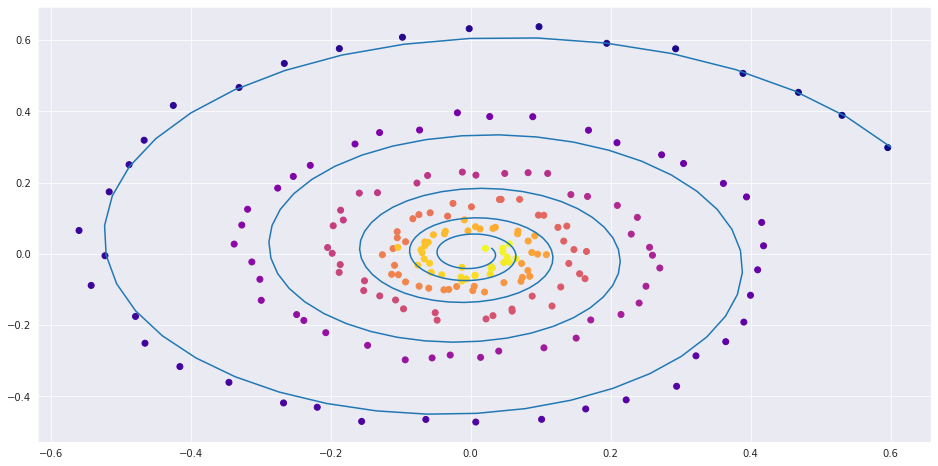

In [ ]:
conduct_experiment(ode_true, ode_trained, 500, "linear")

In [ ]:
func = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[-1., 0.]]))
ode_true = NeuralODE(func)

func = NNODEF(2, 16, time_invariant=True)
ode_trained = NeuralODE(func)

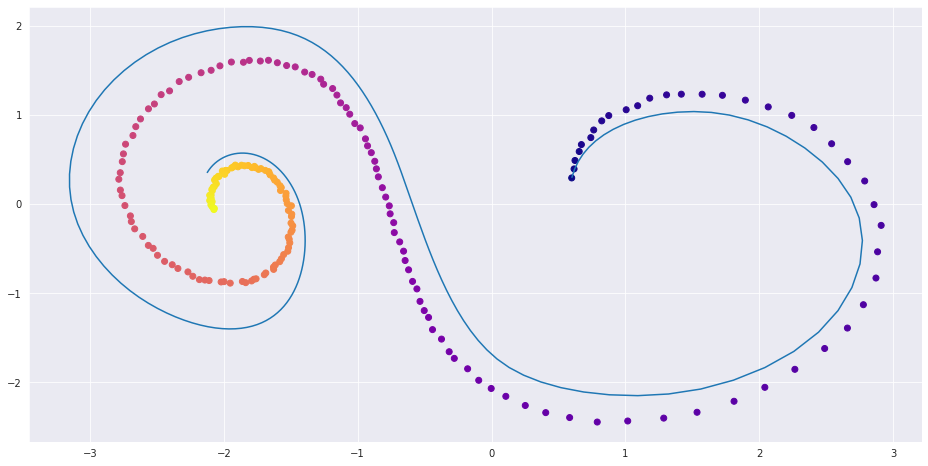

In [ ]:
conduct_experiment(ode_true, ode_trained, 3000, "comp", plot_freq=30)

As one can see, Neural ODEs are pretty successful in approximating dynamics.

##ECG Heartbeat Classification (comparison with ResNet)

### Load data

Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab\ Notebooks
#%cd /content/drive/MyDrive/

%ls

/content/drive/MyDrive/Colab Notebooks
 data.zip                             'ML exercises'/
 homework_classification/              Neural_ODE.ipynb
 HW01_Facci_1597454.ipynb              nodup_classification/
'HW01_Facci_1597454_Save&Load.ipynb'   ptbdb_abnormal.csv
 HW02_Facci_1597454.AlexNet_ARGOS      ptbdb_normal.csv
 mitbih_test.csv                       train_dataset/
 mitbih_train.csv


#### Unzip the dataset folder and split in train and test data

We will be using the MIT Beth Israel Hospital (BIH) electrocardiogram dataset for the model comparison. This dataset contains about 110,000 labeled data points. Each sample is annotated as either normal (0), supraventricular premature beat (1), premature ventricular contraction (2), fusion of ventricular and normal beat (3), and finally unclassifiable beat (4). The ECGs were recorded at a frequency of 360 Hz. Thus, each sample was taken over 0.52 seconds since there are 187 measurements per sample. Data was downloaded from kaggle and can be found here: https://www.kaggle.com/shayanfazeli/heartbeat. A description of the data and the sampling procedure used can be found at the data's source: https://www.physionet.org/content/mitdb/1.0.0/.

After having downloaded the .zip file fromn kaggle, rename it as "data.zip" and upload it in the "Colab Notebooks" file in Google Drive.

In [4]:
if not os.path.isfile('mitbih_train.csv') and not os.path.isfile('mitbih_test.csv'):
  !unzip /content/drive/MyDrive/Colab\ Notebooks/data.zip

%cd /content/drive/MyDrive/Colab\ Notebooks

%ls

/content/drive/MyDrive/Colab Notebooks
 data.zip                             'ML exercises'/
 homework_classification/              Neural_ODE.ipynb
 HW01_Facci_1597454.ipynb              nodup_classification/
'HW01_Facci_1597454_Save&Load.ipynb'   ptbdb_abnormal.csv
 HW02_Facci_1597454.AlexNet_ARGOS      ptbdb_normal.csv
 mitbih_test.csv                       train_dataset/
 mitbih_train.csv


In [5]:
mit_train = pd.read_csv('mitbih_train.csv', header=None)
mit_test = pd.read_csv('mitbih_test.csv', header=None)

In [6]:
# Separate target from data
y_train = mit_train[187]
X_train = mit_train.loc[:, :186]

y_test = mit_test[187]
X_test = mit_test.loc[:, :186]

In [7]:
print(f"Train shape: {mit_train.shape}")
print(f"Test shape: {mit_test.shape}")

Train shape: (87554, 188)
Test shape: (21892, 188)


188 columns come from 187 equally spaced measurements of the heartbeat and one label column.

In [8]:
# Proportions of each class - Train Dataset
round(mit_train[187].value_counts(normalize=True).sort_index(), 2)

0.0    0.83
1.0    0.03
2.0    0.07
3.0    0.01
4.0    0.07
Name: 187, dtype: float64

In [9]:
# Proportions of each class - Test Dataset
round(mit_test[187].value_counts(normalize=True).sort_index(), 2)

0.0    0.83
1.0    0.03
2.0    0.07
3.0    0.01
4.0    0.07
Name: 187, dtype: float64

We can see that most of the samples are normal (0). The arrythmias are much less represented in the dataset. Hopefully, our model will still be able to make these classifications and do better than the baseline accuracy of 83%.

In [10]:
def plot_class(label, num_samples):
    sns.lineplot(data=X_train.loc[y_train == label].sample(num_samples).T)
    plt.title(f"Class {label} examples")
    plt.xlabel("Measurement")
    plt.show()

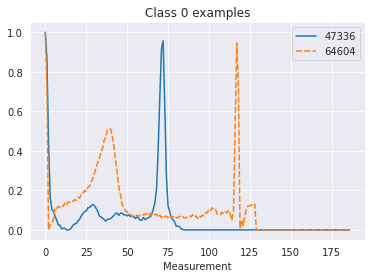

In [ ]:
plot_class(0, 2)

Normal heartbeats. Sharp dropoff at beginning followed by small peak. Then, narrow spike before flatline.

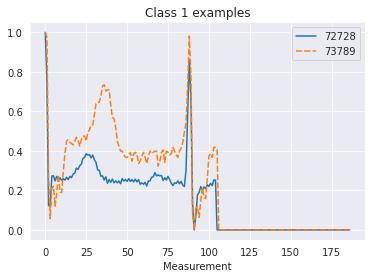

In [ ]:
plot_class(1, 2)

Supraventricular premature beat, otherwise known as class 1. More activity before main peak. After the main spike there is another bump.

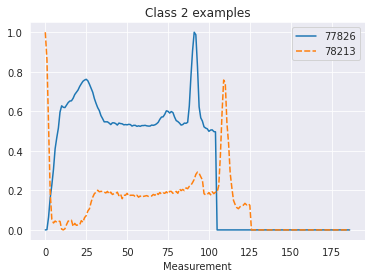

In [ ]:
plot_class(2, 2)

Premature ventricular contraction or class 2. This does not look healthy. A lot of stuff going on towards the front with short main peak.

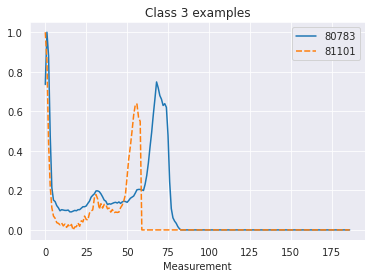

In [ ]:
plot_class(3, 2)

Fusion of ventricular and normal beat: class 3. Everything compressed towards the front of the beat.

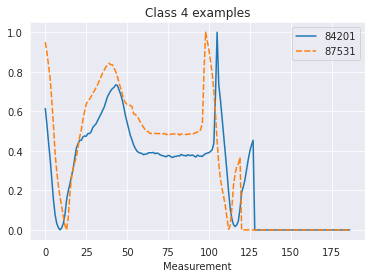

In [ ]:
plot_class(4, 2)

Finally, the unclassifiable beats: class 4. Each sample seems to deviate from the next significantly, which makes sense since these did not fit in any other category. A lot of jagged peaks.

In [11]:
X_train, y_train, X_test, y_test = map(
    torch.from_numpy, 
    (X_train.values, y_train.values, X_test.values, y_test.values)
)

In [12]:
# Convert to 3D tensor
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

In [13]:
print("Output Tensor :" ,X_train)

print("Shape of Output Tensor :", X_train.shape)

Output Tensor : tensor([[[0.9779, 0.9265, 0.6814,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.9601, 0.8632, 0.4615,  ..., 0.0000, 0.0000, 0.0000]],

        [[1.0000, 0.6595, 0.1865,  ..., 0.0000, 0.0000, 0.0000]],

        ...,

        [[0.9061, 0.6245, 0.5959,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.8582, 0.6456, 0.8456,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.9015, 0.8459, 0.8007,  ..., 0.0000, 0.0000, 0.0000]]],
       dtype=torch.float64)
Shape of Output Tensor : torch.Size([87554, 1, 187])


In [14]:
# Batch size
bs = 128

train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

test_ds = TensorDataset(X_test, y_test)
test_dl = DataLoader(test_ds, batch_size=bs * 2)

In [20]:
print("Output Tensor :" ,train_ds[0][0].shape)

Output Tensor : torch.Size([1, 187])


### Models

In [24]:
"""
ResNet and ODENet classes for ECG classification.
Code adapted from:
https://github.com/rtqichen/torchdiffeq/blob/master/examples/odenet_mnist.py
"""

import sys
sys.argv=['']
del sys

parser = argparse.ArgumentParser()
parser.add_argument('--network', type=str, choices=['resnet', 'odenet'], default='odenet')
parser.add_argument('--tol', type=float, default=1e-3)
parser.add_argument('--adjoint', type=eval, default=False, choices=[True, False])
parser.add_argument('--downsampling-method', type=str, default='conv', choices=['conv', 'res'])
parser.add_argument('--nepochs', type=int, default=160)
parser.add_argument('--data_aug', type=eval, default=True, choices=[True, False])
parser.add_argument('--lr', type=float, default=0.1)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--test_batch_size', type=int, default=1000)

parser.add_argument('--save', type=str, default='./experiment1')
parser.add_argument('--debug', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
args = parser.parse_args()

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint


def norm(dim):
    """
    Group normalization to improve model accuracy and training speed.
    """
    return nn.GroupNorm(min(32, dim), dim)


class ResBlock(nn.Module):
    """
    Simple residual block used to construct ResNet.
    """
    def __init__(self, dim):
        super(ResBlock, self).__init__()
        self.gn1 = norm(dim)
        self.conv1 = nn.Conv1d(dim, dim, kernel_size=3, padding=1, bias=False)
        self.gn2 = norm(dim)
        self.conv2 = nn.Conv1d(dim, dim, kernel_size=3, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # Shortcut
        identity = x

        # First convolution
        out = self.gn1(x)
        out = self.relu(out)
        out = self.conv1(out)

        # Second convolution
        out = self.gn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        # Add shortcut
        out += identity

        return out


class ConcatConv1d(nn.Module):
    """
    1d convolution concatenated with time for usage in ODENet.
    """
    def __init__(self, dim_in, dim_out, kernel_size=3, stride=1, padding=0, bias=True, transpose=False):
        super(ConcatConv1d, self).__init__()
        module = nn.ConvTranspose1d if transpose else nn.Conv1d
        self._layer = module(
            dim_in + 1, dim_out, kernel_size=kernel_size, stride=stride, padding=padding,
            bias=bias
        )

    def forward(self, t, x):
        tt = torch.ones_like(x[:, :1, :]) * t
        ttx = torch.cat([tt, x], 1)
        return self._layer(ttx)


class ODEfunc(nn.Module):
    """
    Network architecture for ODENet.
    """
    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.norm1 = norm(dim)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = ConcatConv1d(dim, dim, 3, 1, 1)
        self.norm2 = norm(dim)
        self.conv2 = ConcatConv1d(dim, dim, 3, 1, 1)
        self.norm3 = norm(dim)
        self.nfe = 0    # Number of function evaluations

    def forward(self, t, x):
        self.nfe += 1
        out = self.norm1(x)
        out = self.relu(out)
        out = self.conv1(t, out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(t, out)
        out = self.norm3(out)
        return out


class ODENet(nn.Module):
    """
    Neural ODE.
    Uses ODE solver (dopri5 by default) to yield model output.
    Backpropagation is done with the adjoint method as described in
    https://arxiv.org/abs/1806.07366.
    Parameters
    ----------
    odefunc : nn.Module
        network architecture
    rtol : float
        relative tolerance of ODE solver
    atol : float
        absolute tolerance of ODE solver
    """
    def __init__(self, odefunc):
        super(ODENet, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        out = odeint(self.odefunc, x, self.integration_time, rtol=args.tol, atol=args.tol)
        return out[1]

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value


class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)

    
def count_parameters(model):
    """
    Count number of tunable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Train

In [25]:
# Helpers adapted from https://pytorch.org/tutorials/beginner/nn_tutorial.html

def get_model(is_odenet=True, dim=64, adam=False, **kwargs):
    """
    Initialize ResNet or ODENet with optimizer.
    """
    downsampling_layers = [
        nn.Conv1d(1, dim, 3, 1),
        norm(dim),
        nn.ReLU(inplace=True),
        nn.Conv1d(dim, dim, 4, 2, 1),
        norm(dim),
        nn.ReLU(inplace=True),
        nn.Conv1d(dim, dim, 4, 2, 1)
    ]

    feature_layers = [ODENet(ODEfunc(dim), **kwargs)] if is_odenet else [ResBlock(dim) for _ in range(6)]

    fc_layers = [norm(dim), nn.ReLU(inplace=True), nn.AdaptiveAvgPool1d(1), Flatten(), nn.Linear(dim, 5)]

    model = nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers)

    opt = optim.Adam(model.parameters()) if adam else optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

    return model, opt


def loss_batch(model, loss_func, xb, yb, opt=None):
    """
    Calculate loss and update weights if training.
    """
    loss = loss_func(model(xb.float()), yb.long())

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)


def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    """
    Train neural network model.
    """
    num_batches = len(train_dl)
    
    for epoch in range(epochs):
        print(f"Training... epoch {epoch + 1}")
        
        model.train()   # Set model to training mode
        batch_count = 0
        start = time.time()
        for xb, yb in train_dl:
            batch_count += 1
            curr_time = time.time()
            percent = round(batch_count/len(train_dl) * 100, 1)
            elapsed = round((curr_time - start)/60, 1)
            print(f"\rPercent trained: {percent}%  Time elapsed: {elapsed} min", end='')
            loss_batch(model, loss_func, xb, yb, opt)
            
            

        model.eval()    # Set model to validation mode
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(f"\nval loss: {round(val_loss, 2)}\n")

In [26]:
odenet, odeopt = get_model(adam=False)

In [27]:
resnet, resopt = get_model(is_odenet=False, adam=False)

In [28]:
fit(5, resnet, F.cross_entropy, resopt, train_dl, test_dl)

Training... epoch 1
Percent trained: 100.0%  Time elapsed: 2.9 min
val loss: 0.22

Training... epoch 2
Percent trained: 100.0%  Time elapsed: 2.9 min
val loss: 0.13

Training... epoch 3
Percent trained: 100.0%  Time elapsed: 2.9 min
val loss: 0.11

Training... epoch 4
Percent trained: 100.0%  Time elapsed: 2.9 min
val loss: 0.1

Training... epoch 5
Percent trained: 100.0%  Time elapsed: 2.9 min
val loss: 0.09



In [29]:
fit(5, odenet, F.cross_entropy, odeopt, train_dl, test_dl)

Training... epoch 1
Percent trained: 100.0%  Time elapsed: 14.3 min
val loss: 0.23

Training... epoch 2
Percent trained: 100.0%  Time elapsed: 17.8 min
val loss: 0.16

Training... epoch 3
Percent trained: 100.0%  Time elapsed: 18.7 min
val loss: 0.12

Training... epoch 4
Percent trained: 100.0%  Time elapsed: 18.8 min
val loss: 0.11

Training... epoch 5
Percent trained: 100.0%  Time elapsed: 18.8 min
val loss: 0.12



### Save models

In [30]:
# Specify a path
resnet_path = "resnet.pt"
odenet_path = "odenet.pt"

torch.save(resnet, resnet_path)
torch.save(odenet, odenet_path)

###Load models

In [31]:
# Specify a path
resnet_path = "resnet.pt"
odenet_path = "odenet.pt"

#resnet = torch.load(resnet_path)
#resnet.eval()

#odenet = torch.load(odenet_path)
#odenet.eval()

Sequential(
  (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
  (1): GroupNorm(32, 64, eps=1e-05, affine=True)
  (2): ReLU(inplace=True)
  (3): Conv1d(64, 64, kernel_size=(4,), stride=(2,), padding=(1,))
  (4): GroupNorm(32, 64, eps=1e-05, affine=True)
  (5): ReLU(inplace=True)
  (6): Conv1d(64, 64, kernel_size=(4,), stride=(2,), padding=(1,))
  (7): ODENet(
    (odefunc): ODEfunc(
      (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (relu): ReLU(inplace=True)
      (conv1): ConcatConv1d(
        (_layer): Conv1d(65, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv2): ConcatConv1d(
        (_layer): Conv1d(65, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (norm3): GroupNorm(32, 64, eps=1e-05, affine=True)
    )
  )
  (8): GroupNorm(32, 64, eps=1e-05, affine=True)
  (9): ReLU(inplace=True)
  (10): AdaptiveAvgPool1d(output_size=1)
  (11): Flatten()
  (12): Linear(in_features=64, out_

###Evaluation

In [32]:
def accuracy(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        logits = model(X_test.float())
    preds = torch.argmax(F.softmax(logits, dim=1), axis=1).numpy()
    return (preds == y_test.numpy()).mean()

In [33]:
print(f"ResNet accuracy: {round(accuracy(resnet, X_test, y_test), 3)}")
print(f"ODENet accuracy: {round(accuracy(odenet, X_test, y_test), 3)}")

ResNet accuracy: 0.974
ODENet accuracy: 0.969


Both models perform well on the test set with accuracies above 97%. This is significantly above the baseline accuracy of 83%. Therefore, the models both generalize well. The ResNet has been trained for only 10 minutes with Google Colaboratory (at least one hour in local) while the ODENet for over 70 minutes with Google Colaboratory (at least seven hours in local). However, a benefit of the ODENet can be seen below. It has almost exactly 1/3 of the parameters as the ResNet and yet performed slightly better. This leads to the fact that Neural ODEs use constant memory (although with a high memory overhead due to the adjoint method). 

In [34]:
print("Number of tunable parameters in...")
print(f"    ResNet: {count_parameters(resnet)}")
print(f"    ODENet: {count_parameters(odenet)}")

Number of tunable parameters in...
    ResNet: 182853
    ODENet: 59333


In [35]:
from torchvision import models
from torchsummary import summary

print(resnet)

Sequential(
  (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
  (1): GroupNorm(32, 64, eps=1e-05, affine=True)
  (2): ReLU(inplace=True)
  (3): Conv1d(64, 64, kernel_size=(4,), stride=(2,), padding=(1,))
  (4): GroupNorm(32, 64, eps=1e-05, affine=True)
  (5): ReLU(inplace=True)
  (6): Conv1d(64, 64, kernel_size=(4,), stride=(2,), padding=(1,))
  (7): ResBlock(
    (gn1): GroupNorm(32, 64, eps=1e-05, affine=True)
    (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (gn2): GroupNorm(32, 64, eps=1e-05, affine=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (relu): ReLU(inplace=True)
  )
  (8): ResBlock(
    (gn1): GroupNorm(32, 64, eps=1e-05, affine=True)
    (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (gn2): GroupNorm(32, 64, eps=1e-05, affine=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (relu): ReLU(inplace=True)


In [36]:
print(odenet)

Sequential(
  (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
  (1): GroupNorm(32, 64, eps=1e-05, affine=True)
  (2): ReLU(inplace=True)
  (3): Conv1d(64, 64, kernel_size=(4,), stride=(2,), padding=(1,))
  (4): GroupNorm(32, 64, eps=1e-05, affine=True)
  (5): ReLU(inplace=True)
  (6): Conv1d(64, 64, kernel_size=(4,), stride=(2,), padding=(1,))
  (7): ODENet(
    (odefunc): ODEfunc(
      (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (relu): ReLU(inplace=True)
      (conv1): ConcatConv1d(
        (_layer): Conv1d(65, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (conv2): ConcatConv1d(
        (_layer): Conv1d(65, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (norm3): GroupNorm(32, 64, eps=1e-05, affine=True)
    )
  )
  (8): GroupNorm(32, 64, eps=1e-05, affine=True)
  (9): ReLU(inplace=True)
  (10): AdaptiveAvgPool1d(output_size=1)
  (11): Flatten()
  (12): Linear(in_features=64, out_